### import packages

In [34]:
import datascience as ds
from datascience import *
import numpy as np
from graphviz import Source
import pandas as pd
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.externals import joblib
%matplotlib inline

### tweets data loaded into Jupyter Notebook as Table object

In [35]:
# df = pd.read_csv('Climate1SupportiveLevel.csv')
# df = pd.concat([df.Text, df.SupportiveLabel], axis=1)
# df = df.rename(columns={'SupportiveLabel':'Support'})
# df.to_csv('Climate1SupportiveLevel.csv', index=None)

In [36]:
df = ds.Table.read_table('Climate1SupportiveLevel.csv', sep=',')
df 

Text,Support
RT @kasserolees: Energy is the #1 contributer to climate ...,1
RT @edelman_barbara: @msnbc why don t you have a climate ...,1
RT @OtagoGrad: @anthonyfurey @OskieOckham The data doesn ...,0
The Dow just recorded its 3rd worst day ever. Think @rea ...,0
RT @SimonBanksHB: I am not going to rule out things base ...,0
RT @sydneyleemarco: nothing like an 80 degree october da ...,1
@MerlenesMemos @CNN It's not an act of god. Climate chan ...,1
RT @MikeLevinCA: When asked about climate change my GOP ...,0
RT @gq_jayq: Bet I got 11 years to run it up https://t.c ...,0
No they care about the oil billionaires,0


### Preprocess

In [37]:
X = list(df['Text'])
y = list(df['Support'])

### Check whether the data distribution is balanced

In [38]:
def check(sentiment, index, note='training'):
    if sentiment==0:
        label = 'not supportive'
    else:
        label = 'supportive'
    print('There are {} '.format(df.take(index).where('Support', 
          are.equal_to(sentiment)).size[0][0])+label+' tweets in the '+note+' set.')

#### Model Building

In [39]:
def custom_split(train_index, test_index):
    trainingset = df.take(train_index)
    testingset = df.take(test_index)    
        
    X_train= list(trainingset['Text'])
    y_train= list(trainingset['Support'])
    X_test= list(testingset['Text'])
    y_test= list(testingset['Support'])
    
    return X_train, X_test, y_train, y_test

### classifier

In [40]:
def classifier(X_train, y_train, X_test, fold, max_depth, min_samples_leaf):
    # token_pattern='(([#@]|[0-9]|[a-z]|[A-Z])+)'
    clf = Pipeline(
        [
            ('vect', CountVectorizer(token_pattern='(([#@]|[0-9]|[a-z]|[A-Z])+)',
                                     analyzer = 'word',
                                     min_df = 3)),
            ('clf', DecisionTreeClassifier(criterion='entropy',
                                           random_state = 100,
                                           max_depth = max_depth,
                                           min_samples_leaf = min_samples_leaf))
        ])
    clf.fit(X_train, y_train)
    feature_names = clf.named_steps['vect'].get_feature_names()
    try:
        dot_data = tree.export_graphviz(clf.named_steps['clf'], out_file=None, 
                                        feature_names=feature_names)
        graph = Source(dot_data)
        graph.render('ClimateClassifier-Fold_{}'.format(fold))
    except Exception as e:
        print(e)
    predicted_y_train = clf.predict(X_train)
    predicted_y_test = clf.predict(X_test)
    # save as pickle
    joblib.dump(clf, 'ClimateTeam7PD1.pkl')
    return predicted_y_train, predicted_y_test

In [41]:
c=CountVectorizer(token_pattern='(([#@]|[0-9]|[a-z]|[A-Z])+)',
                                     analyzer = 'word',
                                     min_df = 3)
c.fit(X, y)
c.get_feature_names()

[('#1o5c', 'c'),
 ('#actonclimate', 'e'),
 ('#auspol', 'l'),
 ('#cdnpoli', 'i'),
 ('#climate', 'e'),
 ('#climateaction', 'n'),
 ('#climatebreakdown', 'n'),
 ('#climatechange', 'e'),
 ('#climatechangeisreal', 'l'),
 ('#climateimpactsvic', 'c'),
 ('#dems', 's'),
 ('#emissions', 's'),
 ('#energy', 'y'),
 ('#environment', 't'),
 ('#florida', 'a'),
 ('#forests', 's'),
 ('#globalwarming', 'g'),
 ('#gop', 'p'),
 ('#hurricanemichael', 'l'),
 ('#hurricanemichael2018', '8'),
 ('#ipcc', 'c'),
 ('#ipccreport', 't'),
 ('#liberals', 's'),
 ('#michael', 'l'),
 ('#nets', 's'),
 ('#nswpol', 'l'),
 ('#onpoli', 'i'),
 ('#qldpol', 'l'),
 ('#science', 'e'),
 ('#solar', 'r'),
 ('#sr15', '5'),
 ('#stopadani', 'i'),
 ('#sustainability', 'y'),
 ('#topoli', 'i'),
 ('#trump', 'p'),
 ('#weather', 'r'),
 ('#wentworthbyelection', 'n'),
 ('#wentworthvotes', 's'),
 ('000', '0'),
 ('1', '1'),
 ('10', '0'),
 ('100', '0'),
 ('11', '1'),
 ('12', '2'),
 ('15', '5'),
 ('150', '0'),
 ('18', '8'),
 ('1st', 't'),
 ('2', '2'),

### evaluation

In [42]:
def eval_results(predicted_y_train, y_train, predicted_y_test, y_test, fold):
    accuracy_s = accuracy_score(y_test, predicted_y_test)
    precision_s = precision_score(y_test, predicted_y_test)
    recall_s = recall_score(y_test, predicted_y_test)
    f1_s = f1_score(y_test, predicted_y_test)
    cm_train = confusion_matrix(y_train, predicted_y_train)
    cm_test = confusion_matrix(y_test, predicted_y_test)  
    
    print('Accuracy Score:', accuracy_s)
    print("Precision Score:", precision_s)
    print("Recall Score:", recall_s)
    print("f1 Score:", f1_s)
    print('confusion_matrix of training set is: \n', cm_train, '\n')
    print('confusion_matrix of testing set is: \n', cm_test, '\n')
    print(classification_report(y_test, predicted_y_test))
    
    classes = ['not supportive', 'supportive']
    plt.subplot(2, 5, fold)
    sns.heatmap(cm_train, annot=True, cmap='Blues', yticklabels=classes, xticklabels=classes)
    plt.title('Fold {}: confusion matrix of training set'.format(fold))
    plt.subplot(2, 5, fold+5)
    sns.heatmap(cm_test, annot=True, cmap='Blues', yticklabels=classes, xticklabels=classes)
    plt.title('Fold {}: confusion matrix of testing set'.format(fold))
    return accuracy_s, precision_s, recall_s, f1_s

### k-fold

In [43]:
def k_fold_evaluate(X, y, max_depth, min_samples_leaf):
    # initialization
    accuracy = []
    precision = []
    recall=[]
    f1 = []
    fold = 1
    skf = StratifiedKFold(n_splits=5, random_state=1, shuffle= True)
    
    # build model and collect results
    for train_index, test_index in skf.split(X, y):
        if fold==1:
            list(map(lambda x: check(x, train_index), range(2)))
            list(map(lambda x: check(x, test_index, note='testing'), range(2)))
        
        X_train, X_test, y_train, y_test = custom_split(train_index, test_index)
        
        predicted_y_train, predicted_y_test = classifier(X_train=X_train, y_train=y_train, 
                                                          X_test=X_test, fold=fold,
                                                          max_depth = max_depth,
                                                          min_samples_leaf = min_samples_leaf)
        
        print('\nFold: {}'.format(fold))
        accuracy_s, precision_s, recall_s, f1_s = eval_results(predicted_y_train, y_train, predicted_y_test, y_test, fold)
        
        accuracy.append(accuracy_s)
        precision.append(precision_s)
        recall.append(recall_s)
        f1.append(f1_s)
        
        metrics_df = pd.DataFrame(
                    {
                        'accuracy': accuracy,
                        'precision': precision,
                        'recall':recall,
                        'f1':f1
                    }
                )
        fold += 1
    return metrics_df

### Tasks

a) A description of model parameters you tried and the associated Stratified k-fold cross validation results for each model parameter choice

b) Describe the model parameters you chose and the rationale of your decision.

c) Double check overfitting risk: Compare the model’s confusion matrix for training data vs the model’s confusion matrix for testing data.

/usr/local/lib/python3.6/dist-packages/datascience/tables.py:192: FutureWarning: Implicit column method lookup is deprecated.
  warnings.warn("Implicit column method lookup is deprecated.", FutureWarning)


There are 453 not supportive tweets in the training set.
There are 572 supportive tweets in the training set.
There are 114 not supportive tweets in the testing set.
There are 144 supportive tweets in the testing set.

Fold: 1
Accuracy Score: 0.6511627906976745
Precision Score: 0.651685393258427
Recall Score: 0.8055555555555556
f1 Score: 0.7204968944099379
confusion_matrix of training set is: 
 [[215 238]
 [100 472]] 

confusion_matrix of testing set is: 
 [[ 52  62]
 [ 28 116]] 

              precision    recall  f1-score   support

           0       0.65      0.46      0.54       114
           1       0.65      0.81      0.72       144

   micro avg       0.65      0.65      0.65       258
   macro avg       0.65      0.63      0.63       258
weighted avg       0.65      0.65      0.64       258


Fold: 2
Accuracy Score: 0.669260700389105
Precision Score: 0.6933333333333334
Recall Score: 0.7272727272727273
f1 Score: 0.7098976109215017
confusion_matrix of training set is: 
 [[265 1

,accuracy,precision,recall,f1
0,0.651163,0.651685,0.805556,0.720497
1,0.669261,0.693333,0.727273,0.709898
2,0.601562,0.617143,0.755245,0.679245
3,0.632812,0.629630,0.832168,0.716867
4,0.640625,0.656442,0.748252,0.699346


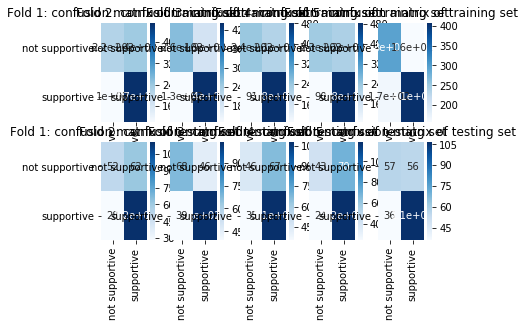

In [44]:
k_fold_evaluate(X, y, max_depth=5, min_samples_leaf=2)

/usr/local/lib/python3.6/dist-packages/datascience/tables.py:192: FutureWarning: Implicit column method lookup is deprecated.
  warnings.warn("Implicit column method lookup is deprecated.", FutureWarning)


There are 453 not supportive tweets in the training set.
There are 572 supportive tweets in the training set.
There are 114 not supportive tweets in the testing set.
There are 144 supportive tweets in the testing set.

Fold: 1
Accuracy Score: 0.6434108527131783
Precision Score: 0.6733333333333333
Recall Score: 0.7013888888888888
f1 Score: 0.6870748299319728
confusion_matrix of training set is: 
 [[273 180]
 [136 436]] 

confusion_matrix of testing set is: 
 [[ 65  49]
 [ 43 101]] 

              precision    recall  f1-score   support

           0       0.60      0.57      0.59       114
           1       0.67      0.70      0.69       144

   micro avg       0.64      0.64      0.64       258
   macro avg       0.64      0.64      0.64       258
weighted avg       0.64      0.64      0.64       258


Fold: 2
Accuracy Score: 0.6536964980544747
Precision Score: 0.684931506849315
Recall Score: 0.6993006993006993
f1 Score: 0.6920415224913494
confusion_matrix of training set is: 
 [[284 

,accuracy,precision,recall,f1
0,0.643411,0.673333,0.701389,0.687075
1,0.653696,0.684932,0.699301,0.692042
2,0.585938,0.597884,0.790210,0.680723
3,0.617188,0.620321,0.811189,0.703030
4,0.605469,0.631250,0.706294,0.666667


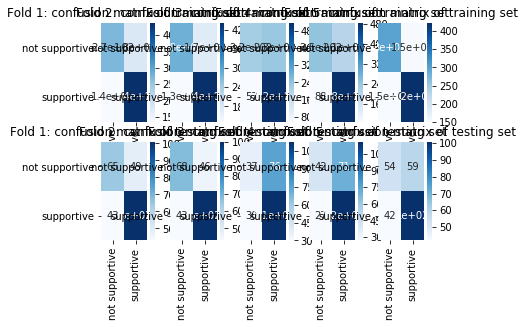

In [45]:
k_fold_evaluate(X, y, max_depth=6, min_samples_leaf=2)

/usr/local/lib/python3.6/dist-packages/datascience/tables.py:192: FutureWarning: Implicit column method lookup is deprecated.
  warnings.warn("Implicit column method lookup is deprecated.", FutureWarning)


There are 453 not supportive tweets in the training set.
There are 572 supportive tweets in the training set.
There are 114 not supportive tweets in the testing set.
There are 144 supportive tweets in the testing set.

Fold: 1
Accuracy Score: 0.6434108527131783
Precision Score: 0.6511627906976745
Recall Score: 0.7777777777777778
f1 Score: 0.7088607594936709
confusion_matrix of training set is: 
 [[237 216]
 [ 82 490]] 

confusion_matrix of testing set is: 
 [[ 54  60]
 [ 32 112]] 

              precision    recall  f1-score   support

           0       0.63      0.47      0.54       114
           1       0.65      0.78      0.71       144

   micro avg       0.64      0.64      0.64       258
   macro avg       0.64      0.63      0.62       258
weighted avg       0.64      0.64      0.63       258


Fold: 2
Accuracy Score: 0.6498054474708171
Precision Score: 0.6802721088435374
Recall Score: 0.6993006993006993
f1 Score: 0.689655172413793
confusion_matrix of training set is: 
 [[284 

,accuracy,precision,recall,f1
0,0.643411,0.651163,0.777778,0.708861
1,0.649805,0.680272,0.699301,0.689655
2,0.593750,0.615385,0.727273,0.666667
3,0.593750,0.608939,0.762238,0.677019
4,0.609375,0.633540,0.713287,0.671053


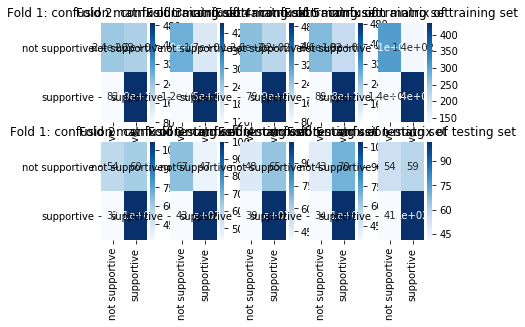

In [46]:
k_fold_evaluate(X, y, max_depth=7, min_samples_leaf=1)

### chosen parameters: `max_depth=7, min_samples_leaf=2`

Because the 5-fold f1 score of max_depth=7, min_samples_leaf=2 are better.

/usr/local/lib/python3.6/dist-packages/datascience/tables.py:192: FutureWarning: Implicit column method lookup is deprecated.
  warnings.warn("Implicit column method lookup is deprecated.", FutureWarning)


There are 453 not supportive tweets in the training set.
There are 572 supportive tweets in the training set.
There are 114 not supportive tweets in the testing set.
There are 144 supportive tweets in the testing set.

Fold: 1
Accuracy Score: 0.6395348837209303
Precision Score: 0.6491228070175439
Recall Score: 0.7708333333333334
f1 Score: 0.7047619047619048
confusion_matrix of training set is: 
 [[237 216]
 [ 85 487]] 

confusion_matrix of testing set is: 
 [[ 54  60]
 [ 33 111]] 

              precision    recall  f1-score   support

           0       0.62      0.47      0.54       114
           1       0.65      0.77      0.70       144

   micro avg       0.64      0.64      0.64       258
   macro avg       0.63      0.62      0.62       258
weighted avg       0.64      0.64      0.63       258


Fold: 2
Accuracy Score: 0.6498054474708171
Precision Score: 0.6802721088435374
Recall Score: 0.6993006993006993
f1 Score: 0.689655172413793
confusion_matrix of training set is: 
 [[284 

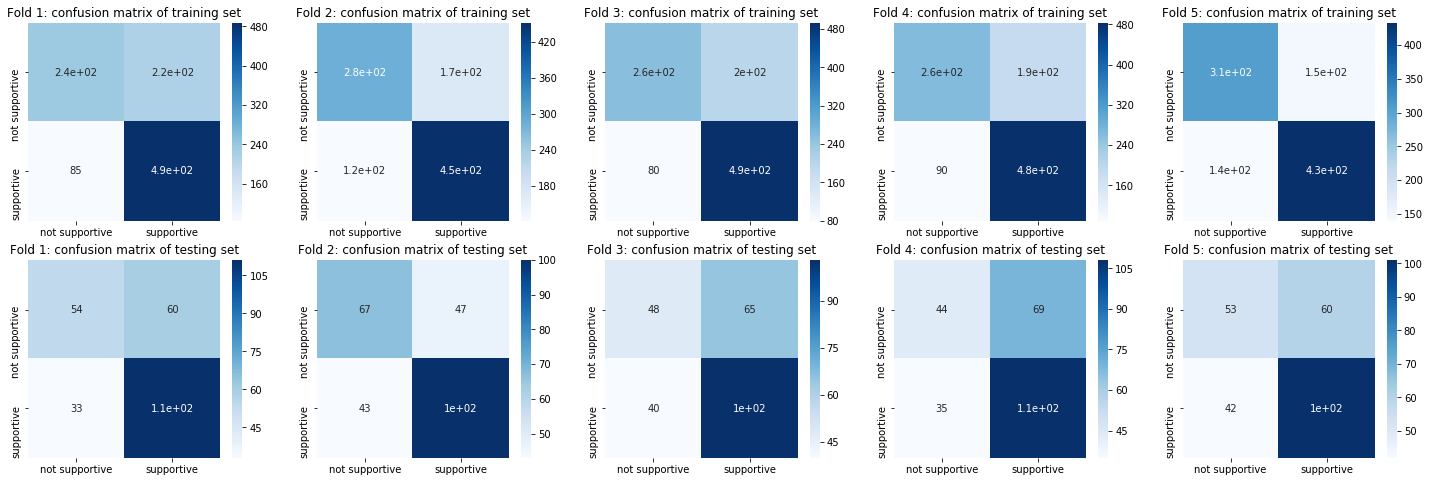

In [47]:
plt.figure(figsize=(25, 8))
metrics_df = k_fold_evaluate(X, y, max_depth=7, min_samples_leaf=2)
plt.show()

In [48]:
metrics_df

,accuracy,precision,recall,f1
0,0.639535,0.649123,0.770833,0.704762
1,0.649805,0.680272,0.699301,0.689655
2,0.589844,0.613095,0.720280,0.662379
3,0.593750,0.610169,0.755245,0.675000
4,0.601562,0.627329,0.706294,0.664474


### reload pickle

In [49]:
clf2 = joblib.load('ClimateTeam7PD1.pkl')
y_pred = clf2.predict(X)
f1_score(y_pred, y)

0.7335164835164835